In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
from numpyro.contrib.nested_sampling import NestedSampler #Need to have jaxns v 1.1.2 or earlier for this to work
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

/home/hughmc/anaconda3/envs/nestconda_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO[2023-03-17 22:08:53,895]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-03-17 22:08:53,896]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-03-17 22:08:53,896]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-03-17 22:08:53,901]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-03-17 22:08:53,902]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugi

In [3]:
def potential(x,y):
    x_width = 30
    y_width = 60

    out = 0
    for i in [0,1]:
        for j in [0,1]:
            dx = x - (180 + 360*i)
            dy = y - (180 + 360*j)
            r2 = (dx/x_width)**2 + (dy/y_width)**2
            out += jnp.exp(-r2/2)

    return(out)

def model():

    x = numpyro.sample('x', numpyro.distributions.Uniform(0,800))
    y = numpyro.sample('y', numpyro.distributions.Uniform(0,800))

    numpyro.factor('log_pot', jnp.log( potential(x,y) + 1E-15 ) ) #Add buffer to avoid log-zero issues which mess with some samplers

In [4]:
#Create a nested sampler from the model. This is acts as both the MCMC object and the sampling kernel
ns = NestedSampler(model)

print("Starting Sampling")
ns.run(jax.random.PRNGKey(1))
print("Sampling Done")

Starting Sampling
Sampling Done


WARNING[2023-03-17 22:09:02,984]: Parameter x in chain Chain 0 is not constrained
WARNING[2023-03-17 22:09:03,024]: Parameter y in chain Chain 0 is not constrained


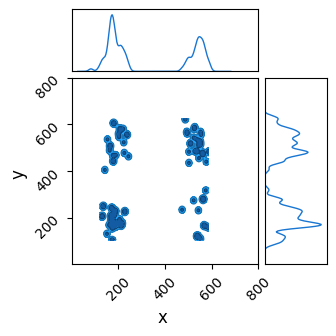

In [5]:
c_nest = ChainConsumer()

nest_out = ns.get_samples(jax.random.PRNGKey(1),100)

c_nest.add_chain([nest_out['x'],nest_out['y']], parameters=['x','y'])
c_nest.plotter.plot(extents={"x": (0,800), "y": (0,800)})

plt.show()

In [10]:
start_positions = ns.get_samples(jax.random.PRNGKey(1),5)

from numpyro.infer.util import unconstrain_fn
init_params = jax.vmap(lambda p: unconstrain_fn(model, model_args, model_kwargs, p))(start_positions)

print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    infer.NUTS(model = model),
    num_warmup=0,
    num_samples=3,
    num_chains=5,
    progress_bar=False,
    chain_method = 'sequential',
)

sampler.run(jax.random.PRNGKey(10), init_params=init_params)
print("Done")

ImportError: cannot import name 'unconstrain_fn' from 'numpyro.infer.util' (/home/hughmc/anaconda3/envs/nestconda_dev/lib/python3.10/site-packages/numpyro/infer/util.py)

In [18]:
chains = sampler.get_samples()

print("Starting Positions")
for pos in start_positions: print(pos,":\t",+start_positions[pos])

print("Total No. Samples in main chain:")
print(chains['x'].shape)
for pos in chains: print(pos,":\t",+chains[pos])

Starting Positions
x :	 [587.36707 522.5249  156.05652 223.1214  216.75415]
y :	 [482.78903 541.8898  493.17975 521.8364  560.7812 ]
Total No. Samples in main chain:
(15,)
x :	 [7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02
 7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02 9.403955e-36
 9.403955e-36 9.403955e-36 7.999999e+02 7.999999e+02 7.999999e+02]
y :	 [7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02
 7.999999e+02 7.999999e+02 7.999999e+02 7.999999e+02 9.403955e-36
 9.403955e-36 9.403955e-36 7.999999e+02 7.999999e+02 7.999999e+02]


# HMC Test

WARNING[2023-03-17 21:23:13,965]: Parameter x in chain Chain 0 is not constrained
WARNING[2023-03-17 21:23:13,984]: Parameter y in chain Chain 0 is not constrained


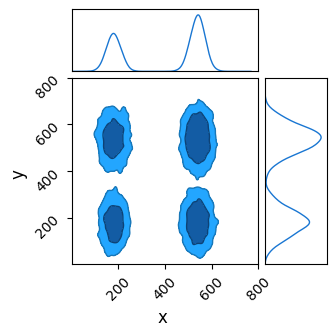

In [24]:
testsampler = numpyro.infer.MCMC(
    infer.NUTS(model = model),
    num_warmup=200,
    num_samples=2000,
    num_chains=5,
    progress_bar=False,
    chain_method = 'sequential',
)
testsampler.run(jax.random.PRNGKey(10))

c = ChainConsumer()
testout = testsampler.get_samples()

c.add_chain([testout['x'],testout['y']], parameters=['x','y'])
c.plotter.plot(extents={"x": (0,800), "y": (0,800)})

plt.show()